# Predict movie categories

In [1]:
from fastai.text import *
import pandas as pd
tok = Tokenizer(lang="en")
bs=24


In [4]:
!mkdir "data/"

In [5]:
query = """
SELECT movie_name, category_0
FROM EVIC.movies
"""

movies = pd.read_gbq(query, project_id="spike-sandbox")

movies.to_csv("data/movie_titles.csv")

In [6]:
sample = "movie_titles.csv" 
data_lm = TextLMDataBunch.from_csv('data/', sample, tokenizer=tok,
                                   text_cols=['movie_name'],
                                   bs=bs, valid_pct=0.1,
                                 label_cols="category_0")

data_lm.show_batch(rows=3)

idx,text
0,"way xxmaj home , xxmaj the ( xxmaj xxunk ) ( 2002 ) xxbos xxmaj associate , xxmaj the ( 1996 ) xxbos xxmaj blood on the xxmaj sun ( 1945 ) xxbos xxmaj henry : xxmaj portrait of a xxmaj serial xxmaj killer , xxmaj part 2 ( 1998 ) xxbos xxmaj xxunk xxmaj xxunk ( 1936 ) xxbos xxmaj xxunk , xxmaj the ( 1994 ) xxbos xxmaj"
1,xxmaj creek xxmaj xxunk ( 2003 ) xxbos xxmaj rambo : xxmaj first xxmaj blood xxmaj part xxup ii ( 1985 ) xxbos xxmaj siegfried & xxmaj roy : xxmaj the xxmaj magic xxmaj box ( 1999 ) xxbos xxmaj anastasia ( 1997 ) xxbos xxmaj when xxmaj willie xxmaj comes xxmaj xxunk xxmaj home ( 1950 ) xxbos xxmaj inferno ( 1980 ) xxbos xxmaj evening ( 2007 )
2,"xxbos xxmaj xxunk xxmaj list , xxmaj the ( 2007 ) xxbos xxmaj only xxmaj you ( 1994 ) xxbos xxmaj on the xxmaj xxunk ( 1954 ) xxbos xxmaj music of the xxmaj heart ( 1999 ) xxbos xxmaj meatballs xxmaj part xxup ii ( 1984 ) xxbos xxmaj hotel de xxmaj love ( 1996 ) xxbos xxmaj one xxmaj night xxmaj stand ( 1997 ) xxbos xxmaj xxunk"


## Load pretrained model here

In [17]:
learn = language_model_learner(data_lm, AWD_LSTM)
                              # pretrained_fnames=pretrained_data)

In [ ]:
#5e-02, 1e-02, 1

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


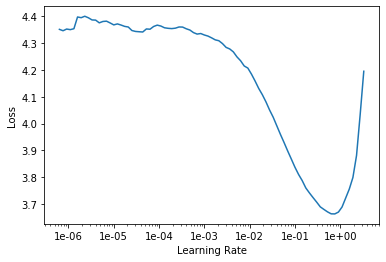

In [9]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(4, 2e-2) #moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.102193,2.074856,0.612330,00:04
1,2.517686,2.031537,0.618452,00:04
2,2.252835,2.018795,0.624745,00:04
3,2.077729,2.027003,0.622024,00:04


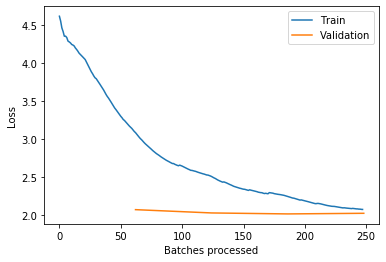

In [19]:
learn.recorder.plot_losses()

In [20]:
learn.save_encoder('enc_step1')

In [27]:
learn.load_encoder('enc_step1');

In [28]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.007914,2.023676,0.621174,00:04
1,2.000463,2.021361,0.621854,00:04


In [29]:
learn.save_encoder('enc_step2')

In [34]:
learn.load_encoder('enc_step2');

In [35]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.979577,2.022604,0.621429,00:04


In [36]:
learn.save_encoder('enc_step3')

In [37]:
learn.load_encoder('enc_step3');

In [38]:
learn.fit_one_cycle(7, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.952833,2.024534,0.622619,00:04
1,1.963326,2.020859,0.621769,00:04
2,1.958457,2.024731,0.622959,00:04
3,1.968778,2.024497,0.622024,00:04
4,1.936448,2.024257,0.623214,00:04
5,1.936372,2.025301,0.622279,00:04
6,1.931705,2.024789,0.623044,00:04


In [39]:
learn.save_encoder('movie_encoder')

## Train category here

In [49]:
movies.head(3)

,movie_name,category_0
0,Caught Up (1998),Crime
1,Mrs. Parker and the Vicious Circle (1994),Drama
2,Frisk (1995),Drama


In [40]:
#Random sample
movies = movies.sample(frac=1, replace=False)

In [41]:
movies.head(3)

,movie_name,category_0
2679,Ringu 0: Bâsudei (2000),Drama
2851,Moulin Rouge (2001),Drama
1248,28 Days (2000),Drama


In [42]:
path = ''
bs=20#64
data_clas = TextClasDataBunch.from_df(path, movies[0:8000],
                                      movies[8000:-1],
                                      vocab=data_lm.train_ds.vocab,
                                      text_cols='movie_name',
                                      label_cols='category_0', bs=bs)

/home/ubuntu/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
(no genres listed)
  if getattr(ds, 'warn', False): warn(ds.warn)


In [43]:
data_clas.save('data_clas.pkl')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [44]:
data_clas.show_batch()

text,target
"xxbos xxmaj friend xxmaj is a xxmaj treasure , a ( a.k.a . xxmaj who xxmaj finds a xxmaj friend xxmaj finds a xxmaj treasure ) ( xxmaj chi xxmaj trova xxmaj un xxmaj xxunk , xxmaj trova un xxmaj xxunk ) ( 1981 )",Action
xxbos xxmaj lone xxmaj wolf and xxmaj cub : xxmaj baby xxmaj cart at the xxmaj river xxmaj xxunk ( xxmaj kozure xxmaj ôkami : xxmaj xxunk no kawa no ubaguruma ) ( 1972 ),Action
"xxbos xxmaj buffalo xxmaj bill and the xxmaj indians , or xxmaj xxunk xxmaj bull 's xxmaj history xxmaj lesson ( a.k.a . xxmaj buffalo xxmaj bill and the xxmaj indians ) ( 1976 )",Comedy
xxbos xxmaj once xxmaj upon a xxmaj time in xxmaj china xxup iii ( xxmaj wong xxmaj fei - hung tsi sam : xxmaj xxunk xxunk ) ( 1993 ),Action
xxbos xxmaj crimson xxmaj rivers 2 : xxmaj angels of the xxmaj xxunk ( xxmaj les xxmaj xxunk xxunk xxup xxunk xxmaj les anges de xxunk ) ( 2004 ),Action


### Load model you trained in the language model step

In [45]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, path="data")
learn.load_encoder('movie_encoder');


In [46]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


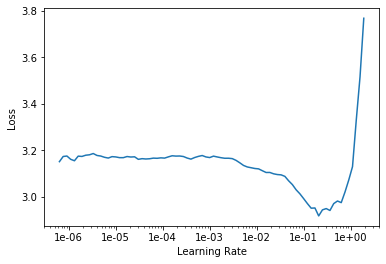

In [47]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(5, 5e-2),# moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.036142,1.962662,0.301605,00:06
1,1.968997,2.107739,0.321015,00:06
2,1.995920,2.364010,0.315789,00:06
3,1.934313,1.919259,0.363942,00:06
4,1.935750,1.955836,0.368794,00:06


(None,)

In [49]:
learn.save('cat_1')

In [53]:
learn.load('cat_1');

In [51]:
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18
row_0,,,,,,,,,,,,,,,,,,
0,68,12,3,2,22,11,1,13,1,1,28,0,0,0,3,0,0,0
1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,79,34,12,21,292,23,37,142,1,0,17,2,2,2,3,7,0,9
7,237,97,31,27,448,115,64,624,9,5,93,7,9,7,13,17,4,15
10,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0
11,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [90]:
learn.predict('Exploding ships')

(Category Drama,
 tensor(7),
 tensor([0.0889, 0.0508, 0.0093, 0.0394, 0.2987, 0.0531, 0.0499, 0.3202, 0.0038,
         0.0050, 0.0296, 0.0087, 0.0038, 0.0073, 0.0074, 0.0087, 0.0016, 0.0138]))

In [100]:
learn.predict('Los venegas')

(Category Comedy,
 tensor(4),
 tensor([0.0983, 0.0224, 0.0056, 0.0324, 0.3285, 0.0643, 0.0422, 0.3149, 0.0026,
         0.0107, 0.0318, 0.0105, 0.0045, 0.0057, 0.0049, 0.0095, 0.0008, 0.0104]))

In [80]:
learn.predict('Two stupid dogs')

(Category Comedy,
 tensor(4),
 tensor([6.8725e-02, 1.6494e-02, 5.1081e-03, 3.6803e-02, 5.3321e-01, 3.5063e-02,
         8.9320e-03, 2.5298e-01, 4.0800e-04, 2.6501e-03, 1.5923e-02, 5.9266e-03,
         1.1871e-03, 3.0353e-03, 1.8166e-03, 3.9959e-03, 3.9979e-04, 7.3474e-03]))

In [79]:
learn.predict('Apocalypse')

(Category Drama,
 tensor(7),
 tensor([0.1185, 0.0738, 0.0100, 0.0323, 0.2499, 0.0588, 0.0521, 0.2751, 0.0058,
         0.0092, 0.0419, 0.0086, 0.0074, 0.0066, 0.0158, 0.0098, 0.0027, 0.0217]))

In [54]:
learn.freeze_to(-1)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.970655,2.545075,0.364688,00:06
1,1.932532,1.955781,0.377753,00:06
2,1.885227,1.896858,0.377006,00:06


In [55]:
learn.save('cat_3')

In [59]:
learn.load('cat_3');

In [60]:
learn.freeze_to(-2)
learn.fit_one_cycle(8, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.879283,1.854682,0.380366,00:06
1,1.921123,2.195518,0.387085,00:06
2,1.879223,1.881008,0.378126,00:06
3,1.841357,2.054074,0.377380,00:06
4,1.852694,2.452390,0.393804,00:06
5,1.772028,2.126377,0.402762,00:06
6,1.777892,2.238587,0.404629,00:06
7,1.736462,2.600193,0.403509,00:06


In [61]:
learn.save('cat_4')

In [62]:
learn.load('cat_4');

In [63]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4), 1e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.740630,1.953550,0.406122,00:12
1,1.751644,2.639886,0.404629,00:12


In [64]:
learn.fit_one_cycle(7, slice(1e-4/(2.6**4), 1e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.727681,2.375021,0.409481,00:13
1,1.731702,2.390347,0.406495,00:12
2,1.697250,1.867443,0.409854,00:12
3,1.691844,1.991421,0.407988,00:12
4,1.722714,2.019526,0.407615,00:12
5,1.683873,2.077051,0.409108,00:12
6,1.696597,1.901966,0.412094,00:12


In [65]:
learn.save('cat_5');

In [72]:
learn.load('cat_5');

In [94]:
preds, targets = learn.get_preds()
ind_to_label = {value: key for key, value in learn.data.c2i.items()}

predictions = np.argmax(preds, axis = 1)
conf_mat = pd.crosstab(predictions, targets)
conf_mat.index = [ind_to_label[ind] for ind in conf_mat.index]
conf_mat.columns =  [ind_to_label[col] for col in conf_mat.columns]
conf_mat

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Action,103,19,2,4,31,8,7,26,0,0,11,0,0,0,5,1,1,1
Adventure,13,11,3,1,5,0,1,9,0,0,1,0,0,0,2,0,0,1
Animation,2,2,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Comedy,83,39,15,25,398,35,40,192,2,0,22,2,2,3,2,9,0,9
Crime,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0
Documentary,4,0,1,0,7,1,10,5,0,0,0,0,0,0,0,0,0,0
Drama,173,73,23,17,312,98,44,540,6,5,69,7,9,6,8,14,3,13
Horror,7,0,0,0,10,4,0,4,2,1,38,0,0,0,2,0,0,0
IMAX,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Sci-Fi,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0


In [74]:
learn.predict('Two stupid dogs')

(Category Comedy,
 tensor(4),
 tensor([3.3294e-02, 1.1559e-02, 3.5158e-02, 2.1118e-02, 6.3793e-01, 2.3392e-02,
         5.9233e-03, 2.0445e-01, 2.8212e-04, 6.5526e-04, 2.2325e-03, 4.3727e-05,
         2.0560e-03, 2.4262e-03, 1.6430e-02, 3.3294e-04, 1.8347e-03, 2.4527e-04,
         6.4315e-04]))

In [75]:
learn.predict('Blood hell bath')

(Category Horror,
 tensor(10),
 tensor([1.3615e-01, 1.5395e-02, 7.0291e-04, 1.5777e-03, 5.8741e-02, 8.6401e-02,
         4.8826e-03, 1.4118e-01, 9.3980e-03, 8.5259e-03, 4.4329e-01, 6.2265e-05,
         3.4331e-03, 2.7905e-02, 3.3307e-03, 4.9194e-03, 4.6882e-02, 1.5314e-03,
         5.6889e-03]))

In [76]:
learn.predict('Hounds and skeletons')

(Category Comedy,
 tensor(4),
 tensor([7.6258e-02, 5.3788e-02, 3.0759e-02, 2.8425e-02, 3.4526e-01, 4.1240e-02,
         7.1112e-02, 2.7695e-01, 6.7732e-03, 1.0531e-03, 3.5443e-02, 6.3631e-05,
         3.6782e-03, 1.7812e-03, 7.0268e-03, 6.5698e-03, 7.4713e-03, 9.3777e-04,
         5.4093e-03]))

In [96]:
2000*8000

16000000

In [77]:
learn.predict('My own private')

(Category Drama,
 tensor(7),
 tensor([3.3584e-03, 2.5004e-04, 5.1977e-05, 2.3102e-05, 9.8844e-02, 3.7834e-03,
         2.2642e-04, 8.4049e-01, 5.4050e-06, 8.9385e-11, 1.0633e-02, 1.7952e-18,
         3.0803e-02, 1.5480e-08, 9.0053e-05, 1.6889e-07, 1.1440e-02, 2.2584e-14,
         5.8134e-06]))

In [78]:
learn.predict('Adventure time')

(Category Adventure,
 tensor(1),
 tensor([1.5409e-01, 2.8501e-01, 4.6878e-02, 3.4044e-02, 2.0467e-01, 2.0660e-02,
         5.7874e-02, 1.4870e-01, 4.9909e-03, 4.5055e-04, 1.7398e-02, 2.1506e-05,
         2.3074e-03, 6.5234e-04, 2.2371e-03, 1.0359e-02, 3.1637e-03, 7.8318e-04,
         5.7141e-03]))

In [95]:
learn.predict('Red Dead Redemption')

(Category Drama,
 tensor(7),
 tensor([2.3337e-01, 4.1005e-02, 1.2554e-03, 6.6602e-03, 1.4189e-01, 1.2139e-01,
         2.2500e-02, 2.3602e-01, 7.2726e-03, 8.6778e-03, 7.6183e-02, 9.5233e-05,
         8.9372e-03, 1.0624e-02, 4.9255e-03, 1.0553e-02, 3.8236e-02, 3.4051e-03,
         2.6991e-02]))